<a href="https://colab.research.google.com/github/machineska/fraud_detection/blob/master/Cybersecurity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import pandas_profiling as pdp

import matplotlib.pyplot as plt

import seaborn as sns

plt.style.use(['dark_background'])

pd.options.display.float_format = '{:,.3f}'.format

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"skaterska","key":"acde96d461603d4c631cb6e4416a40c7"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle competitions download -c ieee-fraud-detection

 61% 32.0M/52.5M [00:00<00:00, 95.0MB/s]
100% 52.5M/52.5M [00:00<00:00, 151MB/s] 
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 100MB/s]
 68% 32.0M/47.3M [00:00<00:00, 123MB/s]
100% 47.3M/47.3M [00:00<00:00, 158MB/s]
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 203MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 161MB/s]


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
def reduce_mem_usage(props, verbose=False):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("\nBefore reduce :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            if verbose:
              # Print current column type
              print("******************************")
              print("Column: ",col)
              print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(
                        np.int8
                    ).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(
                        np.int16
                    ).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(
                        np.int32
                    ).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(
                        np.int64
                    ).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            if verbose:
              # Print new column type
              print("dtype after: ",props[col].dtype)
              print("******************************")
    
    # Print final result
    # print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print(
        "After reduce: ",mem_usg," MB",
        100*mem_usg/start_mem_usg,"% of the initial size"
    )
    return props, NAlist

In [11]:
%%time

train_transaction, train_transaction_na = reduce_mem_usage(
    pd.read_csv(
        '/content/train_transaction.csv.zip', compression='zip'
    )
)

test_transaction, test_transaction_na = reduce_mem_usage(
    pd.read_csv(
        '/content/test_transaction.csv.zip', compression='zip'
    )
)

train_id, train_id_na = reduce_mem_usage(
    pd.read_csv(
        '/content/train_identity.csv.zip', compression='zip'
    )
)

test_id, test_id_na = reduce_mem_usage(
    pd.read_csv(
        '/content/test_identity.csv.zip', compression='zip'
    )
)


Before reduce : 1775.152359008789  MB
After reduce:  450.5463409423828  MB 25.38071386694713 % of the initial size

Before reduce : 1519.2380752563477  MB
After reduce:  376.9102668762207  MB 24.80916408131905 % of the initial size

Before reduce : 45.116905212402344  MB
After reduce:  23.934003829956055  MB 53.04885988362684 % of the initial size

Before reduce : 44.389320373535156  MB
After reduce:  23.54802894592285  MB 53.04886118500284 % of the initial size
CPU times: user 3min 48s, sys: 3.19 s, total: 3min 51s
Wall time: 3min 51s


## Data Properties

In [12]:
print(f'train_transaction shape is: {train_transaction.shape}')
print(f'test_transaction shape is: {test_transaction.shape}')
print(f'\ntrain_id shape is: {train_id.shape}')
print(f'test_id shape is: {test_id.shape}')

train_transaction shape is: (590540, 394)
test_transaction shape is: (506691, 393)

train_id shape is: (144233, 41)
test_id shape is: (141907, 41)


In [13]:
train_transaction.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,"590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000",...,"590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000","590,540.000"
mean,"3,282,269.500",0.035,"7,372,311.310",134.850,"9,898.735",358.569,153.051,198.556,269.401,78.144,"39,140.982","61,374.128",14.092,15.270,0.006,4.092,5.572,9.071,2.848,5.145,4.480,5.240,10.242,4.076,32.540,8.295,234.972,"31,250.300","29,188.534",64.771,"34,404.636",-64.938,"61,218.942",17.662,-0.802,"8,544.540",51.741,-68.873,"58,661.773",-167.492,...,0.593,0.600,0.257,0.288,0.269,1.000,139.741,408.571,230.384,10.996,118.146,4.202,39.172,21.306,43.222,26.750,109.816,247.595,162.148,18.373,42.073,28.327,"56,396.990","56,397.950","56,397.403",219.448,219.559,219.482,219.487,219.623,219.548,99.833,191.065,140.678,0.507,7.390,3.118,6.858,20.219,13.182
std,"170,474.358",0.184,"4,617,223.647",239.163,"4,901.170",159.865,11.659,41.962,113.290,24.596,"32,093.887","15,950.656",133.569,154.669,0.151,68.848,25.787,71.508,61.727,95.379,16.675,95.581,94.336,86.666,129.365,49.544,"3,034.399","32,643.714","32,555.704",200.495,"32,706.521",71.599,"16,249.490",95.944,0.533,"21,907.107",168.153,59.597,"20,076.698",89.032,...,11.810,11.810,1.245,1.307,1.264,0.005,"2,348.530","4,391.489","3,021.272",115.959,352.617,102.331,171.489,95.977,173.691,116.528,"2,269.938","3,979.769","2,792.923",331.834,473.213,381.324,"22,700.236","22,697.877","22,699.217",88.316,88.054,88.235,88.221,87.942,88.085,"2,335.010","4,197.945","2,991.463",91.133,146.090,103.002,250.291,412.196,306.248
min,"2,987,000.000",0.000,"86,400.000",0.251,"1,000.000",99.000,99.000,99.000,99.000,9.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-123.000,0.000,-84.000,0.000,-1.000,-1.000,0.000,-54.000,-84.000,0.000,-194.000,...,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
25%,"3,134,634.750",0.000,"3,027,057.750",43.321,"6,019.000",204.000,150.000,166.000,184.000,87.000,13.000,"65,535.000",1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,88.000,7.000,-123.000,11.000,-84.000,"65,535.000",-1.000,-1.000,0.000,-54.000,-84.000,"65,535.000",-194.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,"65,535.000","65,535.000","65,535.000",255.000,255.000,255.000,255.000,255.000,255.0

In [14]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.500,W,13926,99,150,discover,142,credit,315,87,19,65535,NaN,NaN,1,1,0,0,0,1,0,0,1,0,2,0,1,1,14,65535,13,-123,65535,-84,65535,-1.000,-1.000,...,0,0,0,0,0,1,0.000,117.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,117.000,0.000,0.000,0.000,0.000,65535,65535,65535,255,255,255,255,255,255,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
1,2987001,0,86401,29.000,W,2755,404,150,mastercard,102,credit,325,87,65535,65535,gmail.com,NaN,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,65535,65535,0,65535,-84,65535,-1.000,-1.000,...,0,0,0,0,0,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,65535,65535,65535,255,255,255,255,255,255,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
2,2987002,0,86469,59.000,W,4663,490,150,visa,166,debit,330,87,287,65535,outlook.com,NaN,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,65535,65535,0,65535,-84,65535,-1.000,-1.000,...,0,0,0,0,0,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,65535,65535,65535,255,255,255,255,255,255,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
3,2987003,0,86499,50.000,W,18132,567,150,mastercard,117,debit,476,87,65535,65535,yahoo.com,NaN,2,5,0,0,0,4,0,0,1,0,1,0,25,1,112,112,0,94,0,-84,65535,-1.000,-1.000,...,0,0,0,0,0,1,50.000,"1,758.000",925.000,0.000,354.000,0.000,135.000,0.000,0.000,0.000,50.000,"1,404.000",790.000,0.000,0.000,0.000,65535,65535,65535,255,255,255,255,255,255,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
4,2987004,0,86506,50.000,H,4497,514,150,mastercard,102,credit,420,87,65535,65535,gmail.com,NaN,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0,65535,65535,-123,65535,-84,65535,-1.000,-1.000,...,0,0,1,1,1,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [15]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,70787,-14,-29,-73,-101,-47,-101,-37,-101,100.000,NotFound,9,-480,New,NotFound,166,9,542,144,99,9,NaN,10,99,99,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5,98945,-14,-29,0,-5,-47,-101,-37,-101,100.000,NotFound,49,-300,New,NotFound,166,9,621,500,99,9,NaN,10,99,99,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5,191631,0,0,0,0,-47,-101,0,0,100.000,NotFound,52,-661,Found,Found,121,9,410,142,99,9,NaN,10,99,99,NaN,Found,Found,NaN,chrome 62.0,255,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5,221832,-14,-29,0,-6,-47,-101,-37,-101,100.000,NotFound,52,-661,New,NotFound,225,9,176,507,99,9,NaN,10,99,99,NaN,New,NotFound,NaN,chrome 62.0,255,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0,7460,0,0,1,0,-47,-101,0,0,100.000,NotFound,9,-300,Found,Found,166,15,529,575,99,9,NaN,10,99,99,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24,1280x800,match_status:2,T,F,T,T,desktop,MacOS


## Data Analysis

In [16]:
# target
[c for c in train_transaction.columns if c not in test_transaction.columns]

['isFraud']

In [0]:
# pdp.ProfileReport(train_id)

,0,1
isFraud,0.965,0.035


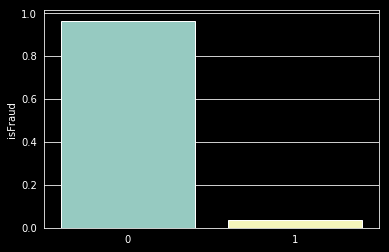

In [40]:
%matplotlib inline

# adjustment for dark theme jupyter
# resource https://github.com/matplotlib/jupyter-matplotlib/issues/25
plt.style.use(['dark_background'])

fc = train_transaction['isFraud'].value_counts(normalize=True).to_frame()

sns.barplot(x=fc.index, y=fc['isFraud'])
# fc.plot.bar()
fc.T

### Fraud Transaction by day and week

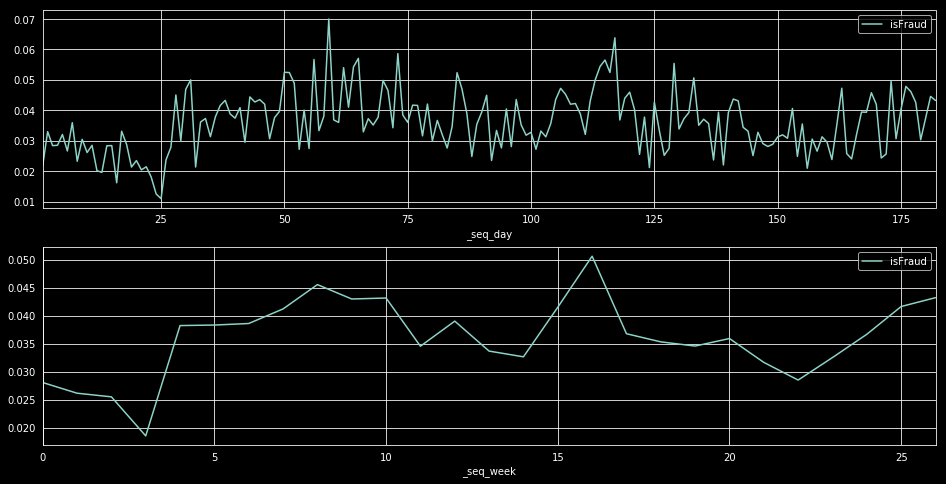

In [41]:
fig,ax = plt.subplots(2, 1, figsize=(16,8))

train_transaction['_seq_day'] = train_transaction['TransactionDT'] // (24*60*60)
train_transaction['_seq_week'] = train_transaction['_seq_day'] // 7
train_transaction.groupby('_seq_day')['isFraud'].mean().to_frame().plot.line(ax=ax[0])
train_transaction.groupby('_seq_week')['isFraud'].mean().to_frame().plot.line(ax=ax[1])

### Fraud transaction rate by weekday, hour, month-day, and year-month

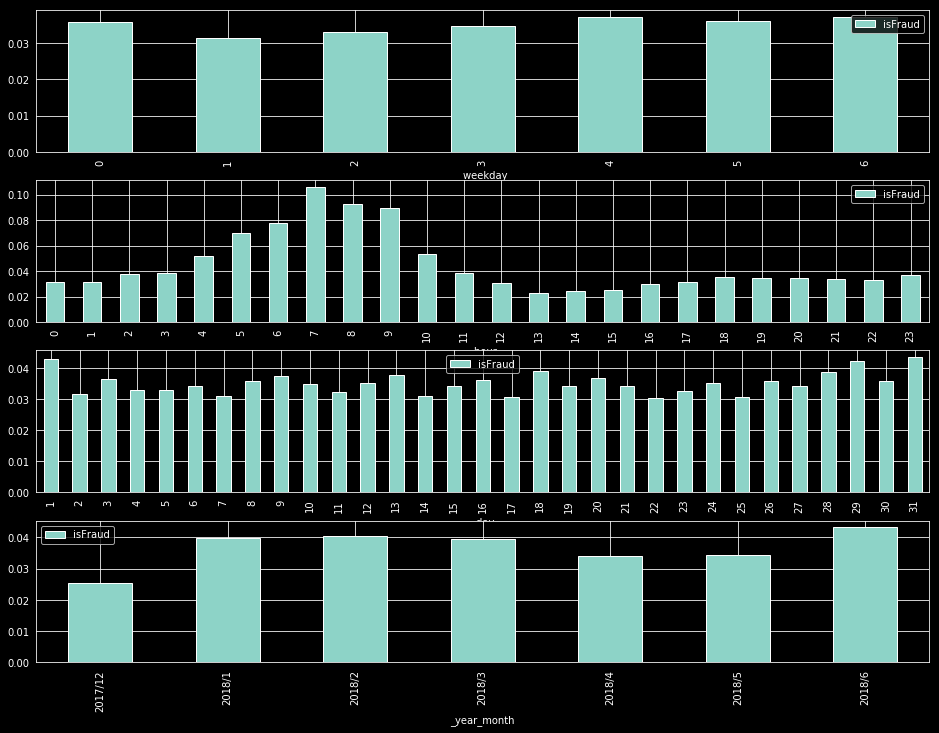

In [42]:
import datetime
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train_transaction['Date'] = train_transaction['TransactionDT'].apply(
    lambda x: (startdate + datetime.timedelta(seconds=x))
)
train_transaction['_year_month'] = train_transaction[
    'Date'
].dt.year.astype(str) + '/' + train_transaction['Date'].dt.month.astype(str)

train_transaction['_weekday'] = train_transaction['Date'].dt.dayofweek
train_transaction['_hour'] = train_transaction['Date'].dt.hour
train_transaction['_day'] = train_transaction['Date'].dt.day

fig,ax = plt.subplots(4, 1, figsize=(16,12))

train_transaction.groupby(
    '_weekday'
)['isFraud'].mean().to_frame().plot.bar(ax=ax[0])

train_transaction.groupby(
    '_hour'
)['isFraud'].mean().to_frame().plot.bar(ax=ax[1])

train_transaction.groupby(
    '_day'
)['isFraud'].mean().to_frame().plot.bar(ax=ax[2])

train_transaction.groupby(
    '_year_month'
)['isFraud'].mean().to_frame().plot.bar(ax=ax[3])

### Fraud transaction rate by weekday-hour

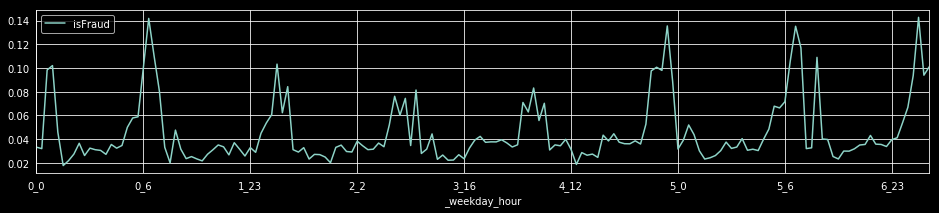

In [43]:
train_transaction['_weekday_hour'] = train_transaction[
    '_weekday'
].astype(str) + '_' + train_transaction['_hour'].astype(str)

train_transaction.groupby(
    '_weekday_hour'
)['isFraud'].mean().to_frame().plot.line(figsize=(16,3))

In [44]:
df = train_transaction.groupby('_weekday')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False)

,isFraud
_weekday,
4,0.037
6,0.037
5,0.036
0,0.036
3,0.035
2,0.033
1,0.031


In [45]:
df = train_transaction.groupby('_hour')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False).head(10)

,isFraud
_hour,
7,0.106
8,0.093
9,0.090
6,0.078
5,0.070
10,0.053
4,0.052
11,0.039
3,0.038


In [46]:
df = train_transaction.groupby(
    '_weekday_hour'
)['isFraud'].mean().to_frame()

df.sort_values(by='isFraud', ascending=False).head(10)

,isFraud
_weekday_hour,
6_7,0.143
0_7,0.142
4_8,0.136
5_8,0.135
5_9,0.117
0_8,0.110
6_10,0.109
5_7,0.106
1_7,0.103


In [47]:
train_transaction['_amount_qcut10'] = pd.qcut(
    train_transaction['TransactionAmt'],10
)

df = train_transaction.groupby(
    '_amount_qcut10'
)['isFraud'].mean().to_frame()

df.sort_values(by='isFraud', ascending=False)

,isFraud
_amount_qcut10,
"(0.25, 25.95]",0.056
"(275.293, 31937.391]",0.051
"(117.0, 159.95]",0.043
"(159.95, 275.293]",0.038
"(68.769, 100.0]",0.036
"(35.95, 49.0]",0.032
"(25.95, 35.95]",0.032
"(57.95, 68.769]",0.029
"(100.0, 117.0]",0.020


In [48]:
# Not all fraud transactions have corresponding identity information.
fraud_id = train_transaction[train_transaction['isFraud'] == 1]['TransactionID']

len(fraud_id)
fraud_id_in_trn = [i for i in fraud_id if i in train_id['TransactionID'].values]

print(
    f'fraud data count:{len(fraud_id)},' 
    f' and in transaction:{len(fraud_id_in_trn)}'
)

fraud data count:20663, and in transaction:11318


### Identity data

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners. (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:

- DeviceType
- DeviceInfo
- id12 - id38

In [49]:
train_id_trn = pd.merge(train_id, train_transaction[['isFraud','TransactionID']])
train_id_f0 = train_id_trn[train_id_trn['isFraud'] == 0]
train_id_f1 = train_id_trn[train_id_trn['isFraud'] == 1]

del train_id_trn

print(train_id_f0.shape, train_id_f1.shape)

(132915, 42) (11318, 42)


In [0]:
def plotHistByFraud(col, bins=20, figsize=(8,3)):
    with np.errstate(invalid='ignore'):
        plt.figure(figsize=figsize)
        plt.hist([train_id_f0[col], train_id_f1[col]], bins=bins, density=True, color=['royalblue', 'orange'])
        
def plotCategoryRateBar(col, topN=np.nan, figsize=(8,3)):
    a, b = train_id_f0, train_id_f1
    if topN == topN: # isNotNan
        vals = b[col].value_counts(normalize=True).to_frame().iloc[:topN,0]
        subA = a.loc[a[col].isin(vals.index.values), col]
        df = pd.DataFrame({'normal':subA.value_counts(normalize=True), 'fraud':vals})
    else:
        df = pd.DataFrame({'normal':a[col].value_counts(normalize=True), 'fraud':b[col].value_counts(normalize=True)})
    df.sort_values('fraud', ascending=False).plot.bar(figsize=figsize)

#### id_01 - id_11

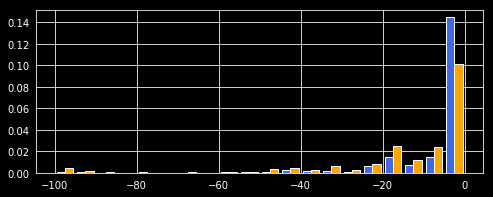

In [51]:
plotHistByFraud('id_01')

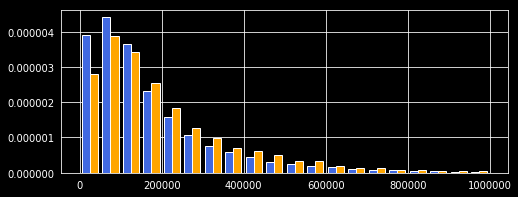

In [52]:
plotHistByFraud('id_02')

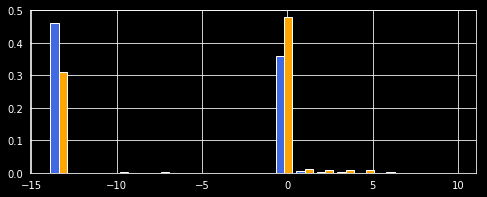

In [53]:
plotHistByFraud('id_03')

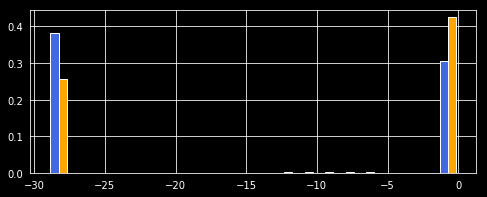

In [54]:
plotHistByFraud('id_04')

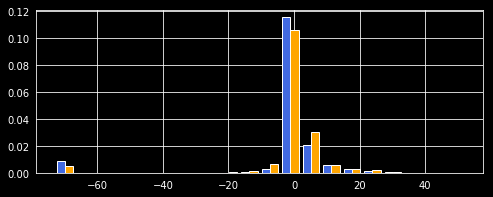

In [55]:
plotHistByFraud('id_05')

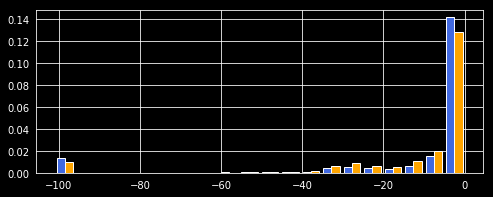

In [56]:
plotHistByFraud('id_06')

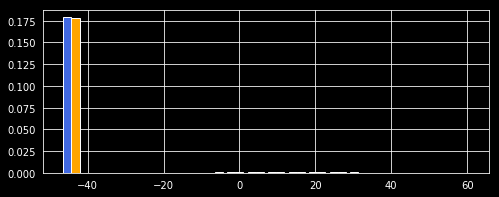

In [57]:
plotHistByFraud('id_07')

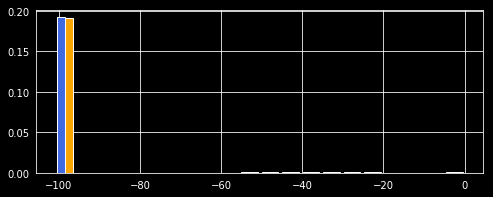

In [58]:
plotHistByFraud('id_08')

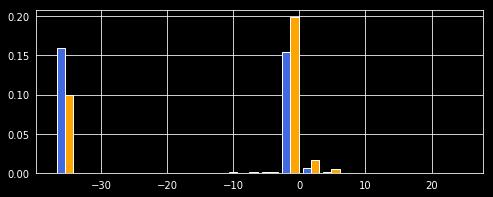

In [59]:
plotHistByFraud('id_09')

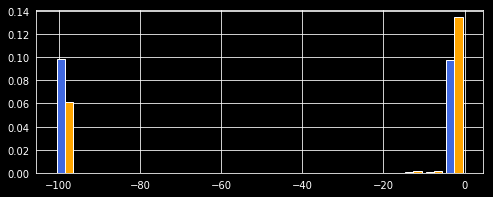

In [60]:
plotHistByFraud('id_10')

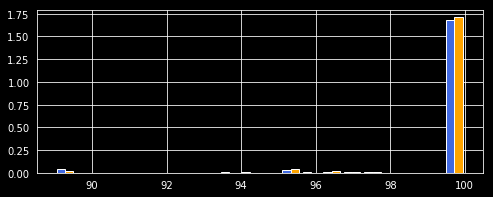

In [61]:
plotHistByFraud('id_11')

In [62]:
numid_cols = [f'id_{str(i).zfill(2)}' for i in range(1,12)]
train_id_f1[['isFraud'] + numid_cols].head(10)

,isFraud,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11
52,1,0,169947,0,0,3,0,-47,-101,0,0,100.000
53,1,0,222455,0,0,0,0,-47,-101,0,0,100.000
54,1,0,271870,0,0,3,0,-47,-101,0,0,100.000
69,1,-20,258138,-14,-29,0,-1,-47,-101,-37,-101,100.000
86,1,-5,141271,-14,-29,9,-81,-47,-101,0,0,97.540
98,1,-20,550210,-14,-29,0,-1,-47,-101,-37,-101,100.000
185,1,-25,59967,-14,-29,1,-12,-47,-101,-37,-101,100.000
201,1,-5,30602,-14,-29,0,-12,-47,-101,0,0,95.080
235,1,-5,4235,-14,-29,0,0,-47,-101,-37,-101,100.000
236,1,0,36004,0,0,0,0,-47,-101,0,0,100.000


In [63]:
train_id_f0[['isFraud'] + numid_cols].head(10)

,isFraud,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11
0,0,0,70787,-14,-29,-73,-101,-47,-101,-37,-101,100.000
1,0,-5,98945,-14,-29,0,-5,-47,-101,-37,-101,100.000
2,0,-5,191631,0,0,0,0,-47,-101,0,0,100.000
3,0,-5,221832,-14,-29,0,-6,-47,-101,-37,-101,100.000
4,0,0,7460,0,0,1,0,-47,-101,0,0,100.000
5,0,-5,61141,3,0,3,0,-47,-101,3,0,100.000
6,0,-15,0,-14,-29,-73,-101,-47,-101,-37,-101,89.000
7,0,0,31964,0,0,0,-10,-47,-101,0,0,100.000
8,0,-10,116098,0,0,0,0,-47,-101,0,0,100.000
9,0,-5,257037,-14,-29,0,0,-47,-101,-37,-101,100.000


#### id_12 - id_38

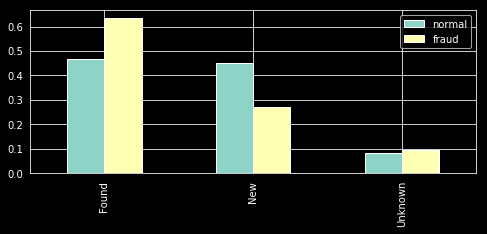

In [64]:
plotCategoryRateBar('id_15')

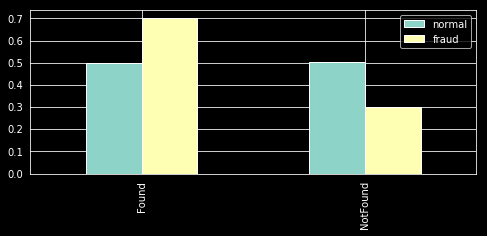

In [65]:
plotCategoryRateBar('id_16')

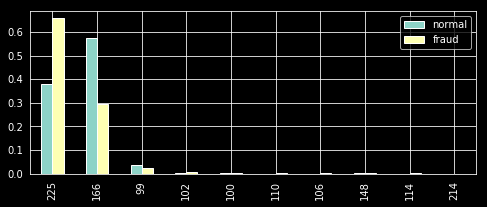

In [66]:
plotCategoryRateBar('id_17', 10)

unique count: 523


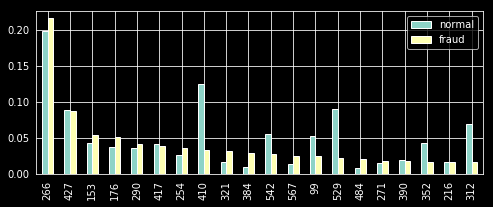

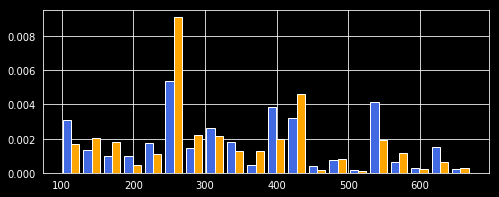

In [68]:
plotCategoryRateBar('id_19', 20)
plotHistByFraud('id_19')
print('unique count:', train_id['id_19'].nunique())

unique count: 395


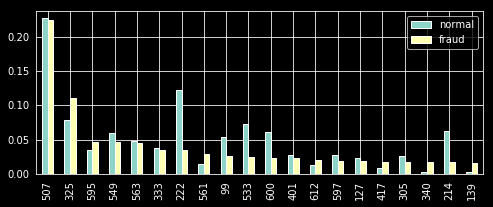

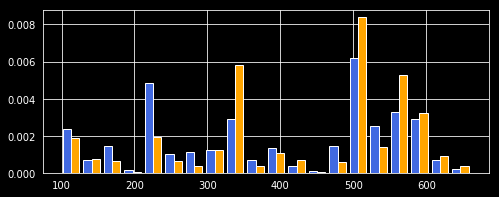

In [69]:
plotCategoryRateBar('id_20', 20)
plotHistByFraud('id_20')
print('unique count:', train_id['id_20'].nunique())

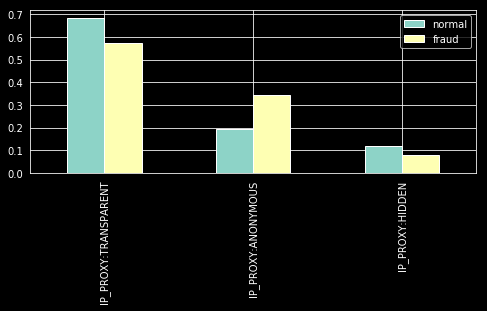

In [70]:
plotCategoryRateBar('id_23')

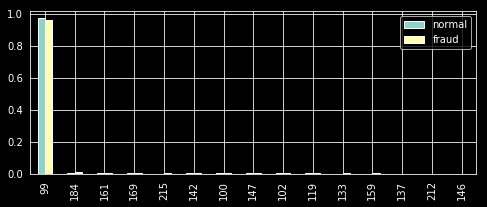

In [74]:
plotCategoryRateBar('id_26', 15)

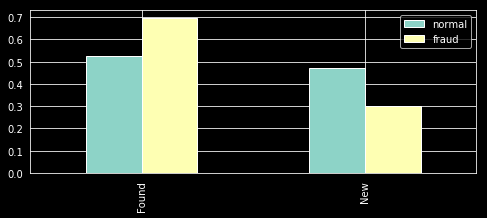

In [75]:
plotCategoryRateBar('id_28')

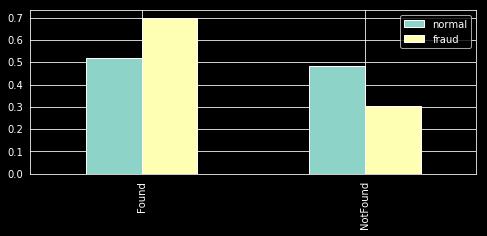

In [76]:
plotCategoryRateBar('id_29')

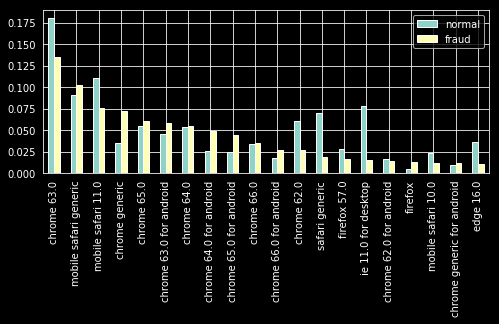

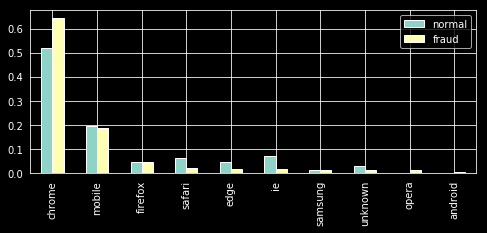

In [77]:
plotCategoryRateBar('id_31', 20)

train_id_f0['_id_31_ua'] = train_id_f0['id_31'].apply(lambda x: x.split()[0] if x == x else 'unknown')
train_id_f1['_id_31_ua'] = train_id_f1['id_31'].apply(lambda x: x.split()[0] if x == x else 'unknown')
plotCategoryRateBar('_id_31_ua', 10)

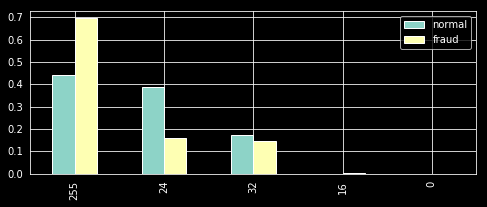

In [78]:
plotCategoryRateBar('id_32')

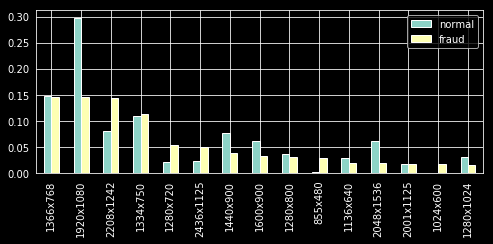

In [79]:
plotCategoryRateBar('id_33', 15)

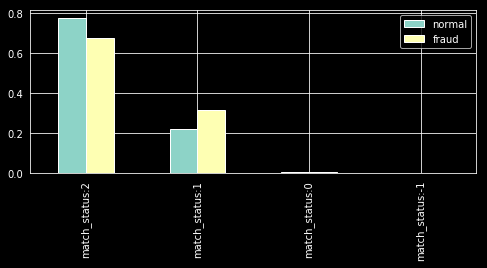

In [80]:
plotCategoryRateBar('id_34')

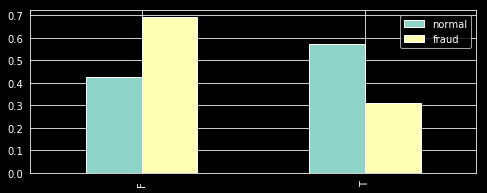

In [81]:
plotCategoryRateBar('id_35')

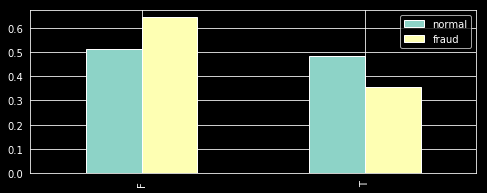

In [82]:
plotCategoryRateBar('id_38')

#### DeviceType, DeviceInfo

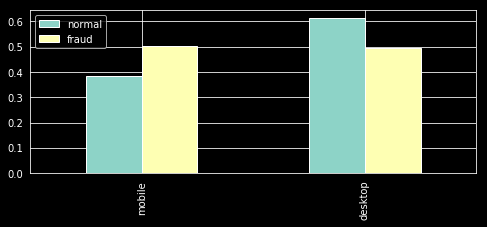

In [83]:
plotCategoryRateBar('DeviceType')

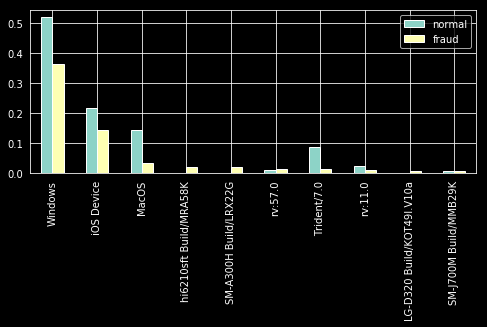

In [84]:
plotCategoryRateBar('DeviceInfo', 10)

### Transaction Data
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

In [0]:
ccols = [f'C{i}' for i in range(1,15)]
dcols = [f'D{i}' for i in range(1,16)]
mcols = [f'M{i}' for i in range(1,10)]
vcols = [f'V{i}' for i in range(1,340)]

In [87]:
train_trn_f0 = train_transaction[train_transaction['isFraud'] == 0]
train_trn_f1 = train_transaction[train_transaction['isFraud'] == 1]
print(train_trn_f0.shape, train_trn_f1.shape)

def plotTrnHistByFraud(col, bins=20):
    with np.errstate(invalid='ignore'):
        plt.figure(figsize=(8,3))
        plt.hist([train_trn_f0[col], train_trn_f1[col]], bins=bins, density=True, color=['royalblue', 'orange'])

def plotTrnLogHistByFraud(col, bins=20):
    with np.errstate(invalid='ignore'):
        plt.figure(figsize=(8,3))
        plt.hist([np.log1p(train_trn_f0[col]), np.log1p(train_trn_f1[col])], bins=bins, density=True, color=['royalblue', 'orange'])
        
def plotTrnCategoryRateBar(col, topN=np.nan):
    a, b = train_trn_f0, train_trn_f1
    if topN == topN: # isNotNan
        vals = b[col].value_counts(normalize=True).to_frame().iloc[:topN,0]
        subA = a.loc[a[col].isin(vals.index.values), col]
        df = pd.DataFrame({'normal':subA.value_counts(normalize=True), 'fraud':vals})
    else:
        df = pd.DataFrame({'normal':a[col].value_counts(normalize=True), 'fraud':b[col].value_counts(normalize=True)})
    df.sort_values('fraud', ascending=False).plot.bar(figsize=(8,3))

(569877, 403) (20663, 403)


#### TransactionDT

In [90]:
train_transaction['TransactionDT'].min(), train_transaction['TransactionDT'].max()

(86400, 15811131)

In [92]:
test_transaction['TransactionDT'].min(), test_transaction['TransactionDT'].max()

(18403224, 34214345)

In [0]:
def appendLagDT(df):
    df = df.assign(
        _TransactionDT_lag = df['TransactionDT'] - df.groupby(
            ['card1','card2','addr1']
        )['TransactionDT'].shift(1)
    )
    return df

train_trn = appendLagDT(train_transaction)
train_trn_f0 = train_trn[train_trn['isFraud'] == 0]
train_trn_f1 = train_trn[train_trn['isFraud'] == 1]

In [97]:
pd.concat([train_trn_f0['_TransactionDT_lag'].describe(), train_trn_f1['_TransactionDT_lag'].describe()], axis=1)

,_TransactionDT_lag,_TransactionDT_lag
count,"529,347.000","19,521.000"
mean,"375,643.458","248,438.238"
std,"1,084,602.353","973,554.469"
min,0.000,0.000
25%,"3,225.000",655.000
50%,"38,171.000","9,153.000"
75%,"236,179.000","83,823.000"
max,"15,599,674.000","14,288,483.000"


In [98]:
sub_df = train_trn[(train_trn['card1'] == 9500) & (train_trn['addr1'] == 204)]
sub_df[['TransactionDT','_TransactionDT_lag','isFraud','TransactionAmt','card1','card2','addr1','addr2']].head(10)

,TransactionDT,_TransactionDT_lag,isFraud,TransactionAmt,card1,card2,addr1,addr2
107,88258,nan,0,226.000,9500,321,204,87
161,89085,827.000,0,107.950,9500,321,204,87
174,89250,165.000,0,107.950,9500,321,204,87
255,90440,"1,190.000",0,54.000,9500,321,204,87
363,92285,"1,845.000",0,29.500,9500,321,204,87
519,95335,"3,050.000",0,57.950,9500,321,204,87
1363,132103,"36,768.000",0,75.000,9500,321,204,87
1453,133921,"1,818.000",0,107.950,9500,321,204,87
1604,136302,"2,381.000",0,59.000,9500,321,204,87
1738,138383,"2,081.000",0,92.990,9500,321,204,87


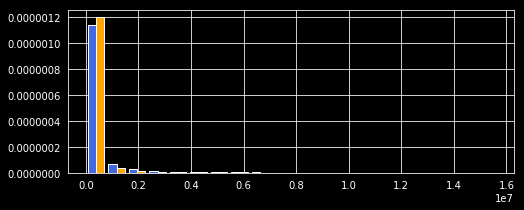

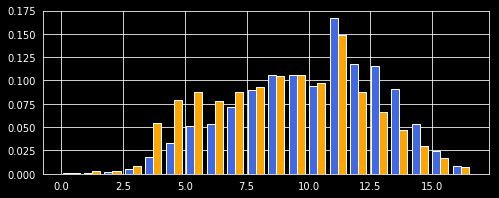

In [99]:
plotTrnHistByFraud('_TransactionDT_lag')
plotTrnLogHistByFraud('_TransactionDT_lag')

#### TransactionAmt

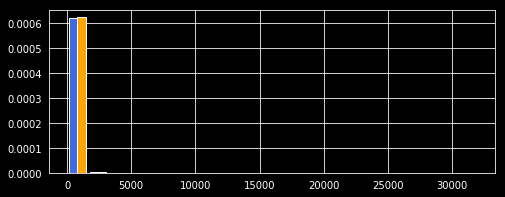

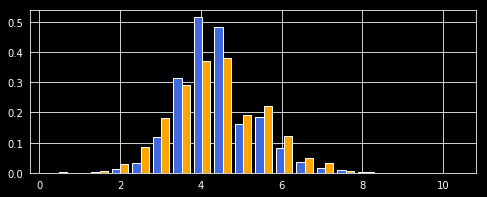

In [100]:
plotTrnHistByFraud('TransactionAmt')
plotTrnLogHistByFraud('TransactionAmt')

In [101]:
amt_desc = pd.concat([train_trn_f0['TransactionAmt'].describe(), train_trn_f1['TransactionAmt'].describe()], axis=1)
amt_desc.columns = ['normal','fraud']
amt_desc

,normal,fraud
count,"569,877.000","20,663.000"
mean,134.340,149.247
std,239.398,232.211
min,0.251,0.292
25%,43.970,35.044
50%,68.500,75.000
75%,120.000,161.000
max,"31,937.391","5,191.000"


In [102]:
train_trn['_amount_max_card1'] = train_trn.groupby(['card1'])['TransactionAmt'].transform('max')
train_trn[['card1','_amount_max_card1']].drop_duplicates().sort_values(by='_amount_max_card1', ascending=False).head(10)


,card1,_amount_max_card1
138,16075,"31,937.391"
445,16661,"6,450.970"
1,2755,"6,085.230"
201,11106,"5,543.230"
214,5033,"5,420.000"
286,7585,"5,366.820"
52407,8945,"5,279.950"
2156,12583,"5,279.950"
107,9500,"5,278.950"
4442,10505,"5,277.950"


In [0]:
def appendLagAmt(df):
    df = df.assign(_TransactionAmt_lag = df['TransactionAmt'] - df.groupby(['card1','card2','addr1'])['TransactionAmt'].shift(1))
    df['_TransactionAmt_lag_gt0'] = df['_TransactionAmt_lag'].apply(lambda x: '0' if np.isnan(x) else '+' if x >=0 else '-')
    return df

train_trn = appendLagAmt(train_trn)
train_trn_f0 = train_trn[train_trn['isFraud'] == 0]
train_trn_f1 = train_trn[train_trn['isFraud'] == 1]

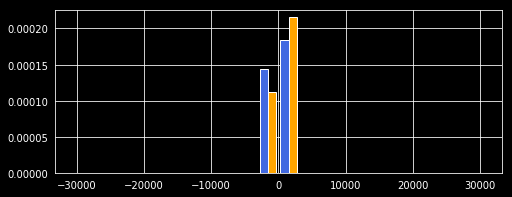

In [104]:
plotTrnHistByFraud('_TransactionAmt_lag')

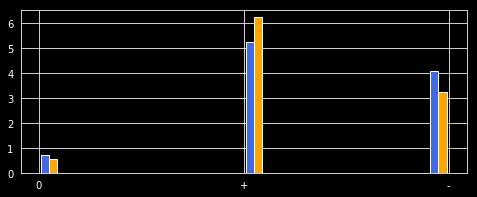

In [105]:
plotTrnHistByFraud('_TransactionAmt_lag_gt0')

In [106]:
sub_df = train_trn[(train_trn['card1'] == 9500) & (train_trn['addr1'] == 204)]
sub_df[['TransactionDT','isFraud','TransactionAmt','_TransactionAmt_lag','card1','card2','addr1','addr2']].head(10)

,TransactionDT,isFraud,TransactionAmt,_TransactionAmt_lag,card1,card2,addr1,addr2
107,88258,0,226.000,nan,9500,321,204,87
161,89085,0,107.950,-118.050,9500,321,204,87
174,89250,0,107.950,0.000,9500,321,204,87
255,90440,0,54.000,-53.950,9500,321,204,87
363,92285,0,29.500,-24.500,9500,321,204,87
519,95335,0,57.950,28.450,9500,321,204,87
1363,132103,0,75.000,17.050,9500,321,204,87
1453,133921,0,107.950,32.950,9500,321,204,87
1604,136302,0,59.000,-48.950,9500,321,204,87
1738,138383,0,92.990,33.990,9500,321,204,87


### ProductCD

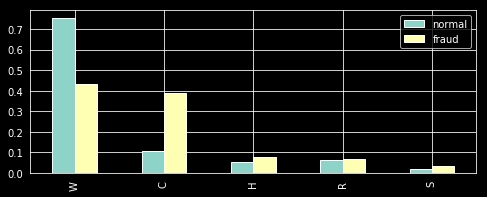

In [107]:
plotTrnCategoryRateBar('ProductCD')

### card1 - card6

In [111]:
cols = [f'card{n}' for n in range(1,7)]
train_trn[cols].isnull().sum()

card1       0
card2       0
card3       0
card4    1577
card5       0
card6    1571
dtype: int64

In [112]:
pd.concat([train_trn[train_trn['card4']=='visa'][cols].head(),
        train_trn[train_trn['card4']=='mastercard'][cols].head()])

,card1,card2,card3,card4,card5,card6
2,4663,490,150,visa,166,debit
5,5937,555,150,visa,226,debit
6,12308,360,150,visa,166,debit
7,12695,490,150,visa,226,debit
8,2803,100,150,visa,226,debit
1,2755,404,150,mastercard,102,credit
3,18132,567,150,mastercard,117,debit
4,4497,514,150,mastercard,102,credit
9,17399,111,150,mastercard,224,debit
10,16496,352,117,mastercard,134,credit


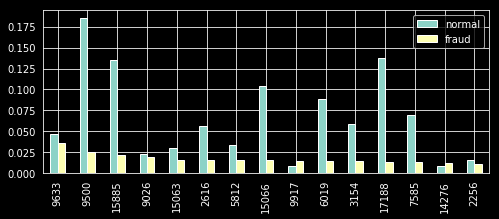

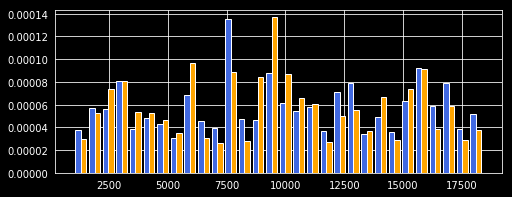

In [113]:
plotTrnCategoryRateBar('card1', 15)
plotTrnHistByFraud('card1', bins=30)

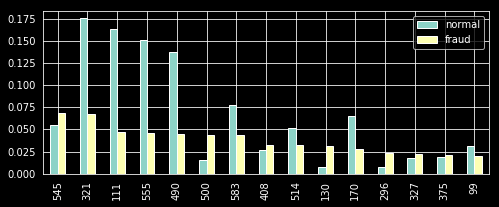

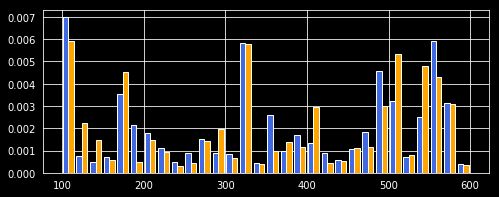

In [114]:
plotTrnCategoryRateBar('card2', 15)
plotTrnHistByFraud('card2', bins=30)

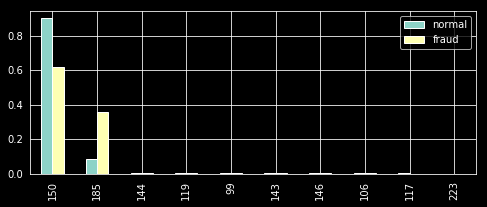

In [115]:
plotTrnCategoryRateBar('card3', 10)

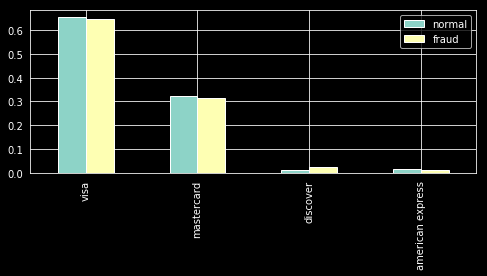

In [116]:
plotTrnCategoryRateBar('card4')

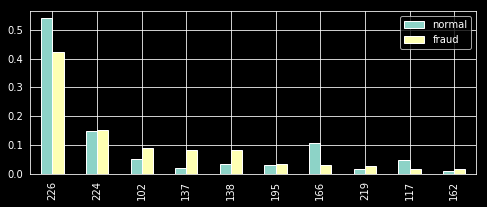

In [117]:
plotTrnCategoryRateBar('card5', 10)

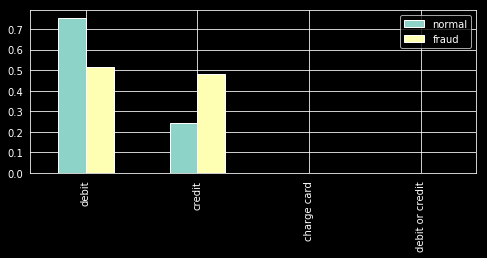

In [118]:
plotTrnCategoryRateBar('card6')

In [119]:
print(len(train_trn))
print(train_trn['card1'].nunique(), train_trn['card2'].nunique(), train_trn['card3'].nunique(), train_trn['card5'].nunique())

train_trn['card_n'] = (train_trn['card1'].astype(str) + '_' + train_trn['card2'].astype(str) \
       + '_' + train_trn['card3'].astype(str) + '_' + train_trn['card5'].astype(str))
print(train_trn['card_n'].nunique())

590540
13553 501 115 120
14845


In [120]:
train_trn['card_n'].value_counts()

9500_321_150_226     14112
15885_545_185_138    10332
17188_321_150_226    10312
7919_194_150_166      8844
15066_170_150_102     7918
12695_490_150_226     7079
6019_583_150_226      6766
12544_321_150_226     6760
2803_100_150_226      6126
7919_194_150_202      6047
7585_553_150_226      5325
10616_583_150_226     5155
12839_321_150_226     5110
3154_408_185_224      4604
18132_567_150_117     4197
15497_490_150_226     3973
16132_111_150_226     3914
2884_490_150_226      3864
16075_514_150_102     3739
11207_361_150_226     3677
10112_360_150_166     3546
7508_321_150_226      3474
10057_225_150_224     3163
12501_490_150_226     3146
7826_481_150_224      3002
16659_170_150_226     2980
12577_268_150_166     2881
2616_327_150_102      2816
5812_408_185_224      2813
7664_490_150_226      2788
                     ...  
5104_555_150_226         1
5470_555_150_226         1
10290_512_150_117        1
5444_555_150_226         1
8719_99_99_99            1
10371_555_150_226        1
1

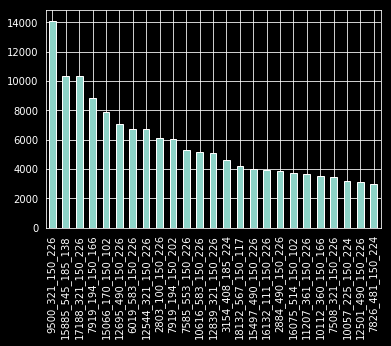

In [121]:
vc = train_trn['card_n'].value_counts()
vc[vc > 3000].plot.bar()

In [122]:
train_trn.groupby(['card_n'])['isFraud'].mean().sort_values(ascending=False)

card_n
4774_555_150_226    1.000
5848_555_223_226    1.000
1509_555_150_226    1.000
6314_555_182_102    1.000
14770_142_185_224   1.000
15749_555_102_226   1.000
2034_399_150_137    1.000
17220_583_150_226   1.000
2702_399_150_223    1.000
4895_555_150_226    1.000
12039_555_223_226   1.000
11403_399_150_223   1.000
2681_555_177_224    1.000
14173_512_150_195   1.000
8185_555_134_224    1.000
2089_168_144_195    1.000
7451_555_142_102    1.000
5859_99_150_99      1.000
11436_555_150_226   1.000
13250_399_150_185   1.000
6273_111_150_226    1.000
16222_555_185_226   1.000
2102_555_143_102    1.000
5872_532_150_224    1.000
11450_555_150_226   1.000
16208_99_150_99     1.000
11476_99_144_195    1.000
12938_216_150_224   1.000
8098_562_150_102    1.000
2154_555_223_226    1.000
                     ... 
3737_310_150_224    0.000
3736_555_150_226    0.000
3771_163_150_224    0.000
3773_399_150_118    0.000
3811_399_150_137    0.000
3774_399_150_132    0.000
3810_555_150_226    0.000
3809_

### Card & Cx

In [123]:
cols = ['TransactionDT','TransactionAmt','isFraud'] + ccols
train_trn[train_trn['card1'] == 9500][cols].head(20)

,TransactionDT,TransactionAmt,isFraud,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
107,88258,226.000,0,3,3,0,0,0,2,0,0,1,0,2,0,8,2
122,88538,80.000,0,21,25,0,0,33,22,0,0,17,0,19,0,99,18
161,89085,107.950,0,1,1,0,0,4,1,0,0,1,0,1,0,5,1
174,89250,107.950,0,3,3,0,0,7,1,0,0,2,0,2,0,31,3
225,89969,43.000,0,2,1,0,0,0,1,0,0,2,0,1,0,7,2
255,90440,54.000,0,1,1,0,0,0,1,0,0,1,0,1,0,1,1
332,91758,100.000,0,1,1,0,1,0,1,0,1,0,1,1,0,0,0
335,91804,100.000,0,1,1,0,1,0,1,0,1,0,1,1,0,0,0
336,91824,100.000,0,1,1,0,1,0,1,0,1,0,1,1,0,0,0
338,91884,100.000,0,1,1,0,1,0,1,0,1,0,1,1,0,0,0


In [124]:
cols = ['TransactionDT','TransactionAmt','isFraud'] + ccols
train_trn[train_trn['card1'] == 4774][cols].head(20)

,TransactionDT,TransactionAmt,isFraud,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
389687,9766493,445.000,1,1,1,0,0,0,1,0,0,1,0,1,0,1,1
393954,9906065,445.000,1,1,1,0,0,0,1,0,0,1,0,1,1,1,1
393970,9906367,445.000,1,1,1,0,0,0,1,0,0,1,0,1,1,1,1
394352,9913683,445.000,1,1,1,0,0,0,1,0,0,1,0,1,1,1,1
394372,9913975,445.000,1,1,1,0,0,0,2,0,0,1,0,1,1,1,1
394375,9914050,426.000,1,1,1,0,0,0,2,0,0,1,0,1,1,1,1


In [125]:
train_trn[train_trn['card1'] == 14770][cols].head(20)

,TransactionDT,TransactionAmt,isFraud,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
78089,1706422,64.713,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1
78134,1706831,64.713,1,1,2,0,1,0,1,1,1,0,1,2,2,1,1


### Card & Dx

In [126]:
cols = ['TransactionDT','TransactionAmt','isFraud'] + dcols
train_trn[train_trn['card1'] == 9500][cols].head(20)

,TransactionDT,TransactionAmt,isFraud,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
107,88258,226.000,0,119,119,28,327,28,-84,65535,-1.000,-1.000,327,226,-84,65535,-194,327
122,88538,80.000,0,416,416,39,-123,65535,-84,65535,-1.000,-1.000,0,343,-84,65535,-194,416
161,89085,107.950,0,125,125,59,124,59,-84,65535,-1.000,-1.000,124,-54,-84,65535,-194,124
174,89250,107.950,0,60,60,15,413,15,-84,65535,-1.000,-1.000,15,276,-84,65535,-194,413
225,89969,43.000,0,86,86,4,299,4,-84,65535,-1.000,-1.000,299,-54,-84,65535,-194,299
255,90440,54.000,0,0,65535,65535,0,65535,-84,65535,-1.000,-1.000,0,0,-84,65535,-194,0
332,91758,100.000,0,0,65535,65535,-123,65535,-84,65535,-1.000,-1.000,65535,-54,-84,65535,-194,-84
335,91804,100.000,0,0,65535,65535,-123,65535,-84,65535,0.042,0.042,65535,-54,-84,65535,-194,-84
336,91824,100.000,0,0,65535,65535,-123,65535,-84,65535,0.042,0.042,65535,-54,-84,65535,-194,-84
338,91884,100.000,0,0,65535,65535,-123,65535,-84,65535,0.042,0.042,65535,-54,-84,65535,-194,-84


In [127]:
cols = ['TransactionDT','TransactionAmt','isFraud'] + dcols
train_trn[train_trn['card1'] == 4774][cols].head(20)

,TransactionDT,TransactionAmt,isFraud,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
389687,9766493,445.000,1,0,65535,65535,0,65535,-84,65535,-1.000,-1.000,0,0,-84,65535,-194,0
393954,9906065,445.000,1,1,1,2,2,2,-84,65535,-1.000,-1.000,2,2,-84,65535,-194,2
393970,9906367,445.000,1,1,1,0,2,0,-84,65535,-1.000,-1.000,2,2,-84,65535,-194,2
394352,9913683,445.000,1,1,1,0,2,0,-84,65535,-1.000,-1.000,2,2,-84,65535,-194,2
394372,9913975,445.000,1,1,1,0,0,65535,-84,65535,-1.000,-1.000,2,2,-84,65535,-194,2
394375,9914050,426.000,1,1,1,0,0,0,-84,65535,-1.000,-1.000,2,2,-84,65535,-194,2


In [128]:
train_trn[train_trn['card1'] == 14770][cols].head(20)

,TransactionDT,TransactionAmt,isFraud,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
78089,1706422,64.713,1,0,65535,65535,0,65535,0,65535,0.750,0.750,0,-54,0,0,0,0
78134,1706831,64.713,1,0,0,0,0,0,0,0,0.750,0.750,0,-54,0,0,0,0


### P_emaildomain, R_emaildomain

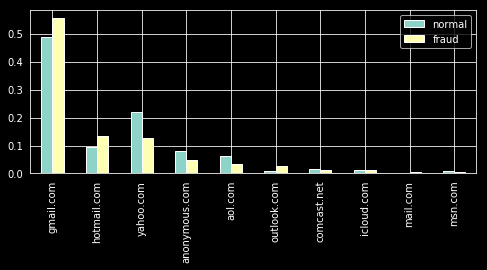

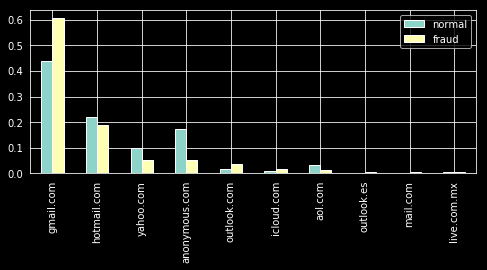

In [133]:
plotTrnCategoryRateBar('P_emaildomain', 10)
plotTrnCategoryRateBar('R_emaildomain',10)

In [134]:
cols = ['TransactionDT','TransactionAmt','isFraud'] + ['addr1','addr2','dist1','dist2','P_emaildomain','R_emaildomain']
train_trn[train_trn['card1'] == 4774][cols].head(20)

,TransactionDT,TransactionAmt,isFraud,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
389687,9766493,445.000,1,253,87,65535,65535,gmail.com,NaN
393954,9906065,445.000,1,253,87,9,65535,gmail.com,NaN
393970,9906367,445.000,1,253,87,9,65535,gmail.com,NaN
394352,9913683,445.000,1,253,87,9,65535,gmail.com,NaN
394372,9913975,445.000,1,253,87,9,65535,mail.com,NaN
394375,9914050,426.000,1,253,87,9,65535,mail.com,NaN


In [135]:
train_trn[train_trn['card1'] == 9500][cols].head(20)

,TransactionDT,TransactionAmt,isFraud,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
107,88258,226.000,0,204,87,113,65535,aol.com,NaN
122,88538,80.000,0,325,87,36,65535,NaN,NaN
161,89085,107.950,0,204,87,65535,65535,gmail.com,NaN
174,89250,107.950,0,204,87,1111,65535,gmail.com,NaN
225,89969,43.000,0,126,87,65535,65535,aol.com,NaN
255,90440,54.000,0,204,87,6,65535,hotmail.com,NaN
332,91758,100.000,0,251,87,65535,65535,gmail.com,anonymous.com
335,91804,100.000,0,251,87,65535,65535,gmail.com,anonymous.com
336,91824,100.000,0,251,87,65535,65535,gmail.com,anonymous.com
338,91884,100.000,0,251,87,65535,65535,gmail.com,anonymous.com


In [136]:
train_trn['P_emaildomain'].fillna('unknown',inplace=True)
train_trn['R_emaildomain'].fillna('unknown',inplace=True)

inf = pd.DataFrame([], columns=['P_emaildomain','R_emaildomain','Count','isFraud'])
for n in (train_trn['P_emaildomain'] + ' ' + train_trn['R_emaildomain']).unique():
    p, r = n.split()[0], n.split()[1]
    df = train_trn[(train_trn['P_emaildomain'] == p) & (train_trn['R_emaildomain'] == r)]
    inf = inf.append(pd.DataFrame([p, r, len(df), df['isFraud'].mean()], index=inf.columns).T)

inf.sort_values(by='isFraud', ascending=False).head(10)

,P_emaildomain,R_emaildomain,Count,isFraud
0,yahoo.com,mail.com,1,1.000
0,anonymous.com,protonmail.com,2,1.000
0,aol.com,mail.com,3,1.000
0,unknown,protonmail.com,6,1.000
0,protonmail.com,gmail.com,4,1.000
0,protonmail.com,protonmail.com,23,1.000
0,yahoo.com,protonmail.com,1,1.000
0,gmail.com,protonmail.com,6,0.833
0,mail.com,hotmail.com,4,0.750
0,aol.com,protonmail.com,3,0.667


# Model Prediction with logistic regression

In [40]:
%%time

train_trn , train_trn_na = reduce_mem_usage(
    pd.read_csv(
        '/content/train_transaction.csv.zip', compression='zip'
    )
)

test_trn, test_trn_na = reduce_mem_usage(
    pd.read_csv(
        '/content/test_transaction.csv.zip', compression='zip'
    )
)

train_id, train_id_na = reduce_mem_usage(
    pd.read_csv(
        '/content/train_identity.csv.zip', compression='zip'
    )
)

test_id, test_id_na = reduce_mem_usage(
    pd.read_csv(
        '/content/test_identity.csv.zip', compression='zip'
    )
)


Before reduce : 1775.152359008789  MB
After reduce:  450.5463409423828  MB 25.38071386694713 % of the initial size

Before reduce : 1519.2380752563477  MB
After reduce:  376.9102668762207  MB 24.80916408131905 % of the initial size

Before reduce : 45.116905212402344  MB
After reduce:  23.934003829956055  MB 53.04885988362684 % of the initial size

Before reduce : 44.389320373535156  MB
After reduce:  23.54802894592285  MB 53.04886118500284 % of the initial size
CPU times: user 4min 1s, sys: 2.65 s, total: 4min 4s
Wall time: 4min 3s


In [0]:
id_cols = list(train_id.columns.values)
trn_cols = list(train_trn.drop('isFraud', axis=1).columns.values)

In [42]:
%%time

X_train = pd.merge(train_trn[trn_cols + ['isFraud']], train_id[id_cols], how='left')

X_test = pd.merge(test_trn[trn_cols], test_id[id_cols], how='left')


X_train_id = X_train.pop('TransactionID')
X_test_id = X_test.pop('TransactionID')
del train_id,train_trn,test_id,test_trn

all_data = X_train.append(X_test, sort=False).reset_index(drop=True)

CPU times: user 25 s, sys: 326 ms, total: 25.3 s
Wall time: 25.4 s


In [43]:
corr_matrix = all_data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
columns_to_drop = [c for c in upper.columns if any(upper[c] > 0.98)]
del upper

print('drop columns:', columns_to_drop)
all_data.drop(columns_to_drop, axis=1, inplace=True)

drop columns: ['C2', 'C6', 'C9', 'C10', 'C11', 'C12', 'C14', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V96', 'V97', 'V98', 'V100', 'V101', 'V102', 'V103', 'V104', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V139', 'V140', 'V141', 'V142', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V153', 'V154', 'V155', 

In [0]:
all_data['_nulls'] = all_data.isnull().sum(axis=1)

In [45]:
all_data.shape

(1097231, 192)

In [0]:
from sklearn import preprocessing
from sklearn.decomposition import PCA


vcols_temp = [f'V{i}' for i in range(1, all_data.shape[1] + 1)]
vcols = [x for x in vcols_temp if x not in columns_to_drop]

sc = preprocessing.MinMaxScaler()

# reduce feature
pca = PCA(n_components=2) #0.99

vcol_pca = pca.fit_transform(sc.fit_transform(all_data[vcols].fillna(-1)))

all_data['_vcol_pca0'] = vcol_pca[:,0]
all_data['_vcol_pca1'] = vcol_pca[:,1]
all_data['_vcol_nulls'] = all_data[vcols].isnull().sum(axis=1)

In [0]:
all_data.drop(vcols, axis=1, inplace=True)

In [0]:
all_data['card4'].fillna('unknown',inplace=True)
all_data['card6'].fillna('unknown',inplace=True)

all_data['P_emaildomain'].fillna('unknown',inplace=True)
all_data['R_emaildomain'].fillna('unknown',inplace=True)

In [0]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#latest-579480
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

all_data['Date'] = all_data['TransactionDT'].apply(
    lambda x: (startdate + datetime.timedelta(seconds=x))
)

all_data['_weekday'] = all_data['Date'].dt.dayofweek
all_data['_hour'] = all_data['Date'].dt.hour
#all_data['_day'] = all_data['Date'].dt.day

all_data['_weekday'] = all_data['_weekday'].astype(str)
all_data['_hour'] = all_data['_hour'].astype(str)
all_data['_weekday__hour'] = all_data['_weekday'] + all_data['_hour']


In [0]:
all_data.drop(['TransactionDT','Date'], axis=1, inplace=True)

In [0]:
all_data['_id_31_ua'] = all_data['id_31'].apply(
    lambda x: x.split()[0] if x == x else 'unknown'
)

In [0]:
all_data['_P_emaildomain__addr1'] = all_data['P_emaildomain'] + '__' + all_data['addr1'].astype(str)
all_data['_card1__card2'] = all_data['card1'].astype(str) + '__' + all_data['card2'].astype(str)
all_data['_card1__addr1'] = all_data['card1'].astype(str) + '__' + all_data['addr1'].astype(str)
all_data['_card2__addr1'] = all_data['card2'].astype(str) + '__' + all_data['addr1'].astype(str)
all_data['_card12__addr1'] = all_data['_card1__card2'] + '__' + all_data['addr1'].astype(str)
all_data['_card_all__addr1'] = all_data['_card12__addr1'] + '__' + all_data['addr1'].astype(str)

In [57]:
import re

all_data['_amount_decimal'] = ((all_data['TransactionAmt'] - all_data['TransactionAmt'].astype(int)) * 1000).astype(int)
all_data['_amount_decimal_len'] = all_data['TransactionAmt'].apply(lambda x: len(re.sub('0+$', '', str(x)).split('.')[1]))
all_data['_amount_fraction'] = all_data['TransactionAmt'].apply(lambda x: float('0.'+re.sub('^[0-9]|\.|0+$', '', str(x))))
all_data[['TransactionAmt','_amount_decimal','_amount_decimal_len','_amount_fraction']].head(10)

,TransactionAmt,_amount_decimal,_amount_decimal_len,_amount_fraction
0,68.500,500,1,0.850
1,29.000,0,0,0.900
2,59.000,0,0,0.900
3,50.000,0,0,0.000
4,50.000,0,0,0.000
5,49.000,0,0,0.900
6,159.000,0,0,0.590
7,422.500,500,1,0.225
8,15.000,0,0,0.500
9,117.000,0,0,0.170


In [0]:
cols = ['ProductCD','card1','card2','card5','card6','P_emaildomain','_card_all__addr1']
#,'card3','card4','addr1','dist2','R_emaildomain'

# amount mean&std
for f in cols:
    all_data[f'_amount_mean_{f}'] = all_data['TransactionAmt'] / all_data.groupby([f])['TransactionAmt'].transform('mean')
    all_data[f'_amount_std_{f}'] = all_data['TransactionAmt'] / all_data.groupby([f])['TransactionAmt'].transform('std')
    all_data[f'_amount_pct_{f}'] = (all_data['TransactionAmt'] - all_data[f'_amount_mean_{f}']) / all_data[f'_amount_std_{f}']

# freq encoding
for f in cols:
    vc = all_data[f].value_counts(dropna=False)
    all_data[f'_count_{f}'] = all_data[f].map(vc)

In [59]:
print('features:', all_data.shape[1])

features: 200


In [60]:
cat_cols = [f'id_{i}' for i in range(12,39)]
for i in cat_cols:
    if i in all_data.columns:
        all_data[i] = all_data[i].astype(str)
        all_data[i].fillna('unknown', inplace=True)

enc_cols = []
for i, t in all_data.loc[:, all_data.columns != 'isFraud'].dtypes.iteritems():
    if t == object:
        enc_cols.append(i)
        #df = pd.concat([df, pd.get_dummies(df[i].astype(str), prefix=i)], axis=1)
        #df.drop(i, axis=1, inplace=True)
        all_data[i] = pd.factorize(all_data[i])[0]
        #all_data[i] = all_data[i].astype('category')
print(enc_cols)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', '_weekday', '_hour', '_weekday__hour', '_id_31_ua', '_P_emaildomain__addr1', '_card1__card2', '_card1__addr1', '_card2__addr1', '_card12__addr1', '_card_all__addr1']


In [0]:
X_train = all_data[all_data['isFraud'].notnull()]
X_test = all_data[all_data['isFraud'].isnull()].drop('isFraud', axis=1)
Y_train = X_train.pop('isFraud')
del all_data

In [71]:
# cols = df.index.difference(['Revenue'])

X_train[['_vcol_pca0', '_vcol_pca1']]
X_test[['_vcol_pca0', '_vcol_pca1']]

,_vcol_pca0,_vcol_pca1
590540,0.015,-0.830
590541,0.016,-0.829
590542,0.016,-0.829
590543,0.018,-0.827
590544,0.017,-0.828
590545,0.016,-0.829
590546,0.017,-0.828
590547,0.017,-0.828
590548,0.015,-0.831
590549,0.197,-0.570


In [74]:
%%time

## Full feature that only remove with corr is train here
from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()


oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

# all_data['_vcol_pca0'] = vcol_pca[:,0]
# all_data['_vcol_pca1'] = vcol_pca[:,1]

clf = logisticRegr
clf.fit(X_train[['_vcol_pca0', '_vcol_pca1']], Y_train)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 774 ms, sys: 9 ms, total: 783 ms
Wall time: 782 ms


In [0]:
oof_preds = clf.predict_proba(X_train[['_vcol_pca0', '_vcol_pca1']])[:,1]
sub_preds = clf.predict_proba(X_test[['_vcol_pca0', '_vcol_pca1']])[:,1]

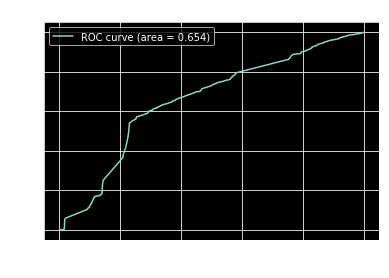

In [86]:
%matplotlib inline

from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(Y_train, oof_preds)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Based on auc score, LogisticRegression not so good for this dataset

In [96]:
clf.score(X_test[['_vcol_pca0', '_vcol_pca1']], Y_train[:506691])

0.9650536520285539